# Stock Price Prediction

In [1]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import plotly.express as px
from copy import copy
from scipy import stats
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from tensorflow import keras
from pylab import rcParams
import statsmodels.api as sm
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

In [15]:
# Uploading the file
df = pd.read_csv('C://Users//kondr//Downloads//Tweets + prices data//CompanyValues.csv', parse_dates=['day_date'])

In [16]:
# Sorting date
df = df[df['ticker_symbol'] != 'GOOG']
df = df.sort_values(by='day_date')
df = df.reset_index()
df= df.drop('index',axis=1)

In [17]:
df

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2010-06-01,123.2400,3650661,124.9700,126.5720,123.0200
1,GOOGL,2010-06-01,243.6667,2664303,242.6868,248.0565,242.5302
2,MSFT,2010-06-01,25.8900,76120800,25.5300,26.3100,25.5200
3,AAPL,2010-06-01,37.2614,218455576,37.0986,37.9914,36.9943
4,MSFT,2010-06-02,26.4600,65259520,26.0600,26.4800,25.7300
...,...,...,...,...,...,...,...
15400,GOOGL,2020-05-29,1433.5200,1852522,1420.4300,1436.7300,1415.9800
15401,MSFT,2020-05-29,183.2500,42146720,182.7300,184.2700,180.4100
15402,AMZN,2020-05-29,2442.3700,3529329,2415.9400,2442.3700,2398.1973
15403,TSLA,2020-05-29,835.0000,11812490,808.7500,835.0000,804.2100


In [4]:
df.isnull().sum()

ticker_symbol    0
day_date         0
close_value      0
volume           0
open_value       0
high_value       0
low_value        0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17528 entries, 0 to 17527
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ticker_symbol  17528 non-null  object        
 1   day_date       17528 non-null  datetime64[ns]
 2   close_value    17528 non-null  float64       
 3   volume         17528 non-null  int64         
 4   open_value     17528 non-null  float64       
 5   high_value     17528 non-null  float64       
 6   low_value      17528 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 958.7+ KB


In [6]:
df.describe()

,day_date,close_value,volume,open_value,high_value,low_value
count,17528,17528.000000,1.752800e+04,17528.000000,17528.000000,17528.000000
mean,2015-12-28 02:07:05.559105536,455.167040,2.025441e+07,455.314451,459.710597,450.466694
min,2010-06-01 00:00:00,15.800000,7.932000e+03,16.140000,16.630000,14.980000
25%,2013-11-26 00:00:00,100.300000,2.075086e+06,99.883750,100.927500,98.940000
50%,2016-04-13 00:00:00,256.500000,4.835618e+06,256.095000,259.604500,252.177400
75%,2018-04-13 00:00:00,735.630000,2.704358e+07,735.740000,742.000000,728.920025
max,2020-05-29 00:00:00,2497.940000,4.624423e+08,2500.000000,2525.450000,2467.270000
std,NaN,469.324583,3.322733e+07,469.588291,473.771691,464.794791


## EDA

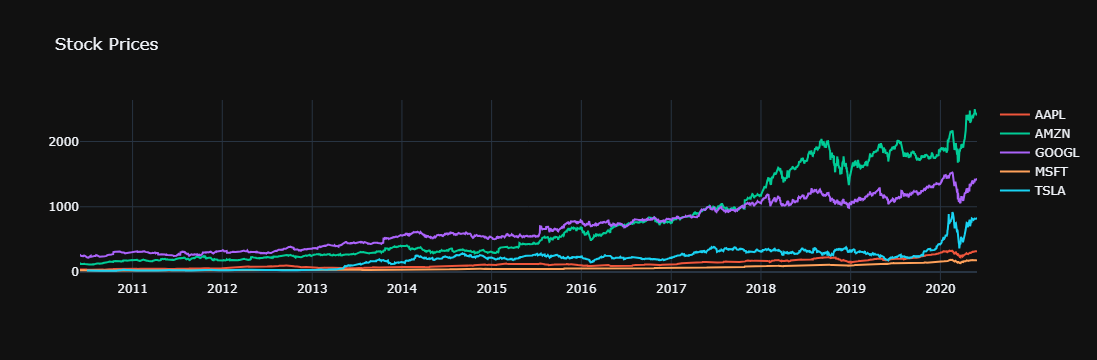

In [18]:
# Stock prices chart
pivot = df.pivot_table('close_value', 'day_date', 'ticker_symbol')
fig = px.line(template='plotly_dark', title = 'Stock Prices')
for i in pivot.columns:
    fig.add_scatter(x =pivot.index, y = pivot[i], name = i)
fig.show()

In [19]:
def individual_stock(name):
    return df[df['ticker_symbol'] == name]

In [40]:
stock = individual_stock('GOOGL')

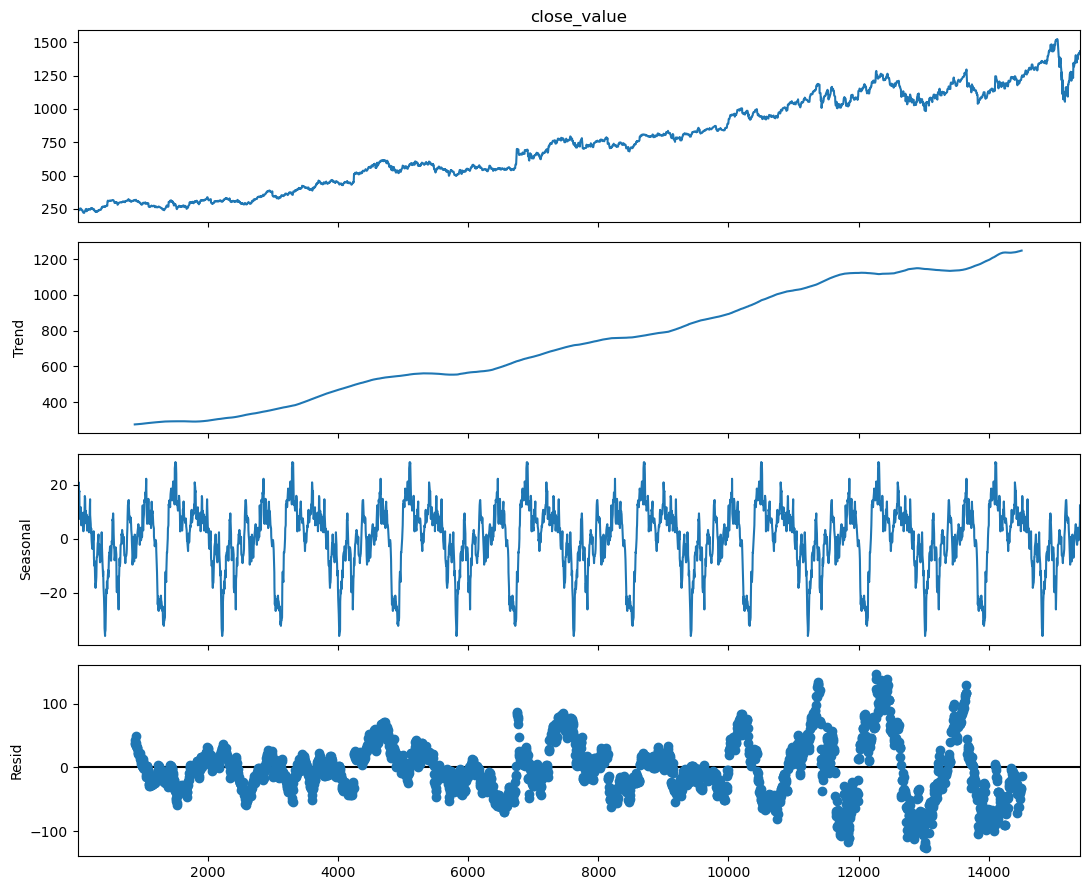

In [41]:
# Seasonal decompose
rcParams['figure.figsize'] = 11, 9
decomposed_stock_volume = sm.tsa.seasonal_decompose(stock['close_value'],period=360) # The frequncy is annual
figure = decomposed_stock_volume.plot()
plt.show()

We can see that the extracted trend and seasonality information does seem reasonable. The residuals are also interesting, showing periods of high variability in the later years of the series.

## Stat models

#### Arima

ARIMA, which stands for
Autoregressive Integrated Moving Average, is applied to time
series data to forecast future values based on historical data.
ARIMA will be used for univariate time series forecasting.

In [42]:
train_size = int(len(stock) * 0.9)
train, test = stock[0:train_size], stock[train_size:len(stock)]

We have moving avarage, so the data is non stationary

In [45]:
def plot_model_results(model):

    model = model
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    mse = mean_squared_error(test['close_value'], forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test['close_value'], forecast)
       
    plt.style.use('dark_background')
    plt.figure(figsize=(20,6))
    plt.plot(train['close_value'], label='Training Data')
    plt.plot(test['close_value'], label='Actual Data', color='green')
    plt.plot(test.index, forecast, label='Forecast', color='red')
    plt.title('Stock Price Prediction')
    plt.legend()
    plt.show()

    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)

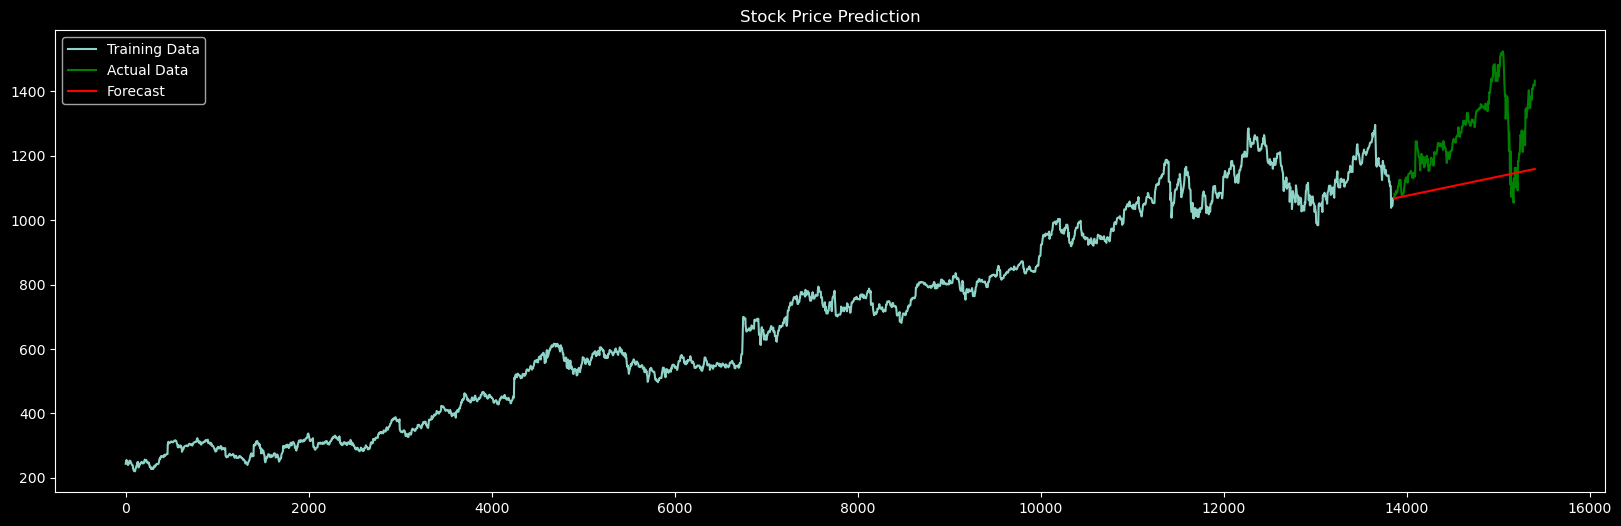

Mean Squared Error: 31149.745099968593
Root Mean Squared Error: 176.49290382326592
Mean Absolute Error: 150.90832269228486


In [46]:
# ARIMA
plot_model_results(ARIMA(train['close_value'], order=(2, 2, 1)))

Lower MSE and RMSE indicates better accuracy

Actual data shows upward trend same as predicted data

#### Exponential smoothing models


Next we will take a look at exponential smoothing models,
which are also widely used for forecasting time series data

##### Single Exponential Smoothing

In [47]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

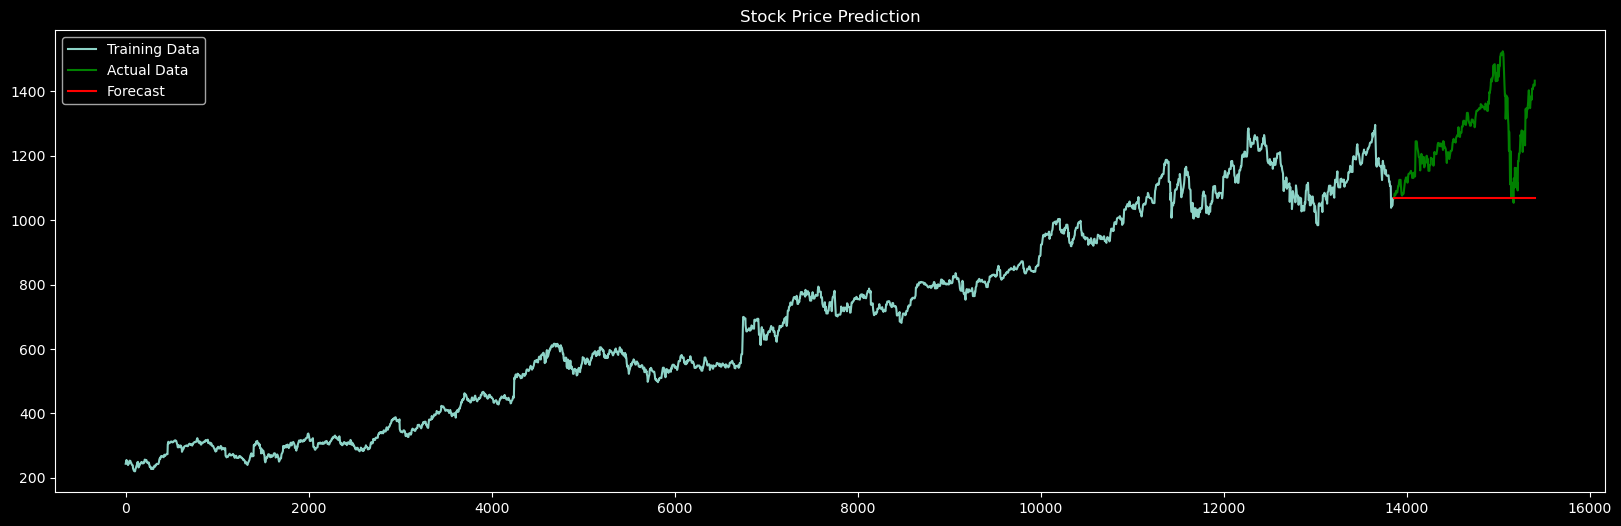

Mean Squared Error: 49558.87879511004
Root Mean Squared Error: 222.61823554037534
Mean Absolute Error: 192.23857158367042


In [48]:
# Single Exponential Smoothing
plot_model_results(SimpleExpSmoothing(train['close_value']))

The actual data in the plot shows a upward trend, while the predicted data shows a flat trend in a horizonta direction
The error values look to be greater than the values for the same metrics from ARIMA.

##### Double exponential smoothing

Double exponential smoothing is an extension of simple
exponential smoothing. In simple exponential smoothing, the
component used for forecasting time series was the level,
while in double exponential smoothing, trend is added as the
second component. Hence, the forecasting happens on both
the level and trend together.
Trend is defined as the direction in which the data changes
over time. The data can be decreasing or increasing over
time and the data can exhibit an upward, a downward trend,
or a stable trend.

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Mean Squared Error: 31111.173552865584
Root Mean Squared Error: 176.38359774328674
Mean Absolute Error: 150.66836516236407


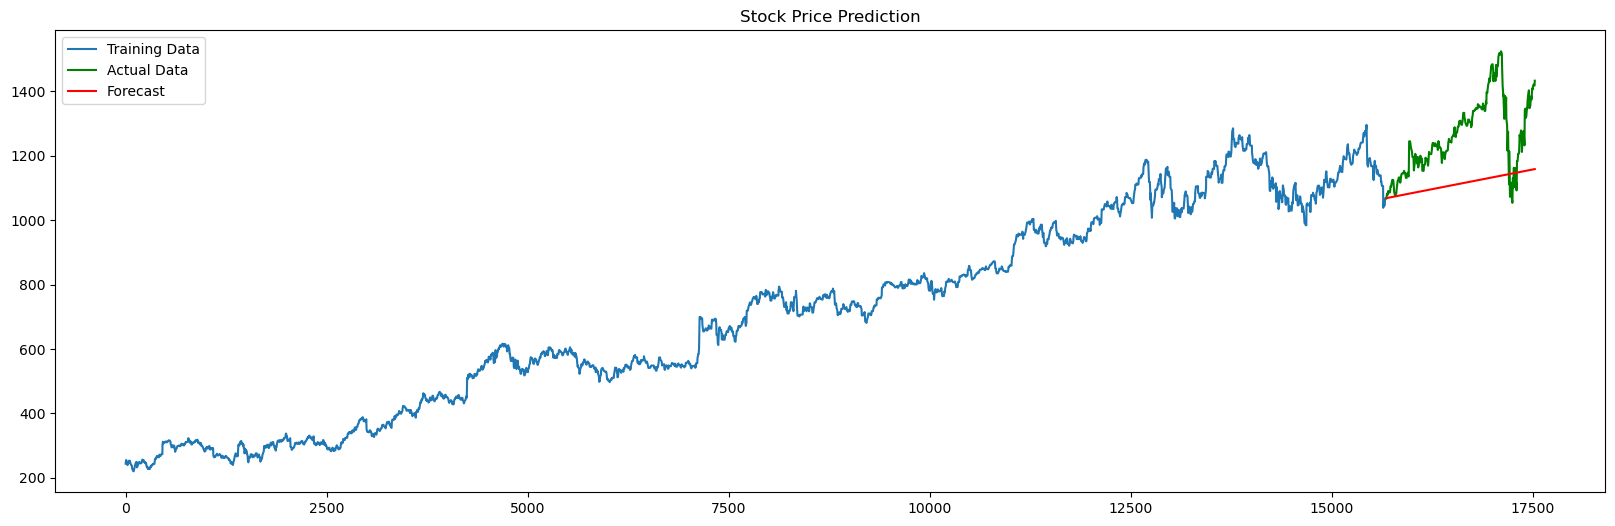

In [17]:
plot_model_results(ExponentialSmoothing(train['close_value'], trend='add'))

The actual data in the plot shows a upward,
while the predicted data also shows aupwardd trend.

##### Triple exponential smoothing



Triple exponential smoothing is a further extension of double
exponential smoothing.

In this method, three
components are used for time series forecasting: level,
trend, and seasonality.

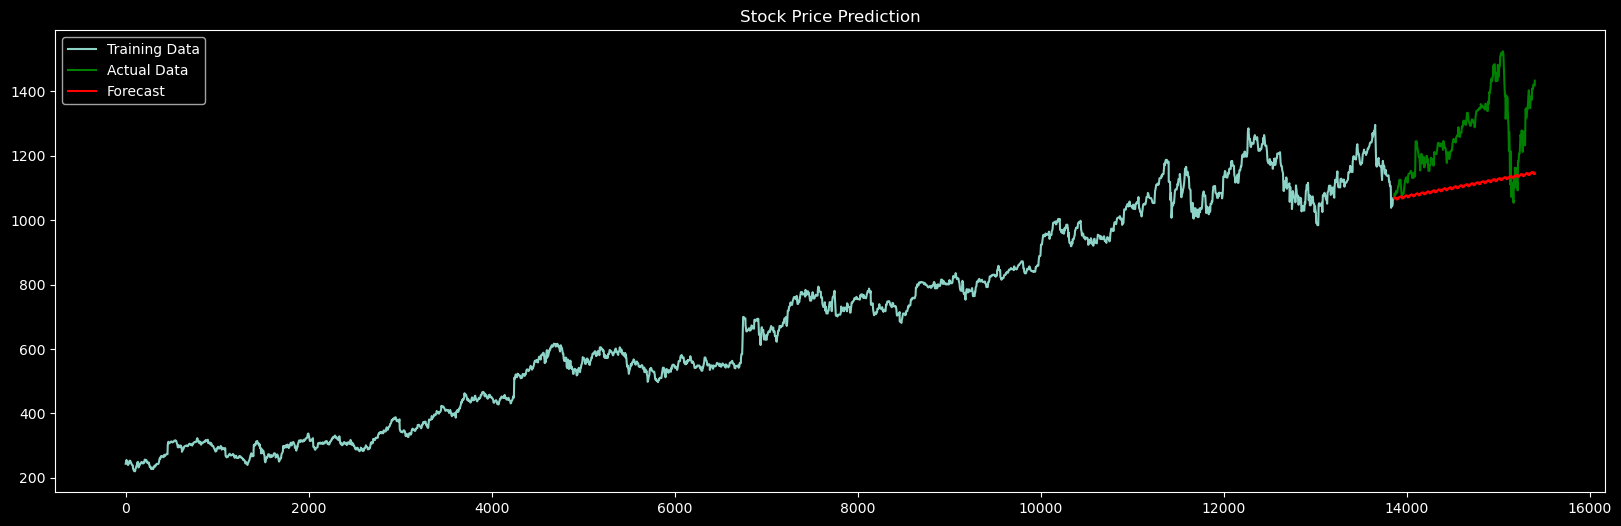

Mean Squared Error: 33283.49022504494
Root Mean Squared Error: 182.43763379589458
Mean Absolute Error: 156.20897555047623


In [51]:
plot_model_results(ExponentialSmoothing(train['close_value'], trend='add', seasonal='add', seasonal_periods=12))

Both plots showing upward trend

##### Prophet

This algorithm was developed by
Facebook and is an open-source algorithm with multiple
options to forecast time series data effectively.

Prophet is an additive method-based algorithm that is
effective in forecasting highly seasonal datasets.

In [19]:
# pip install Prophet

In [52]:
from prophet import Prophet

In [53]:
# Prophet requires specific dataset as input (with ds and y)
df_prophet = stock[['day_date','close_value']]
df_prophet = df_prophet.rename(columns={'day_date': 'ds', 'close_value': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [64]:
# Making model
model = Prophet()
model.fit(df_prophet)

df_future = model.make_future_dataframe(periods=365)  
forecast = model.predict(df_future)

21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:59 - cmdstanpy - INFO - Chain [1] done processing


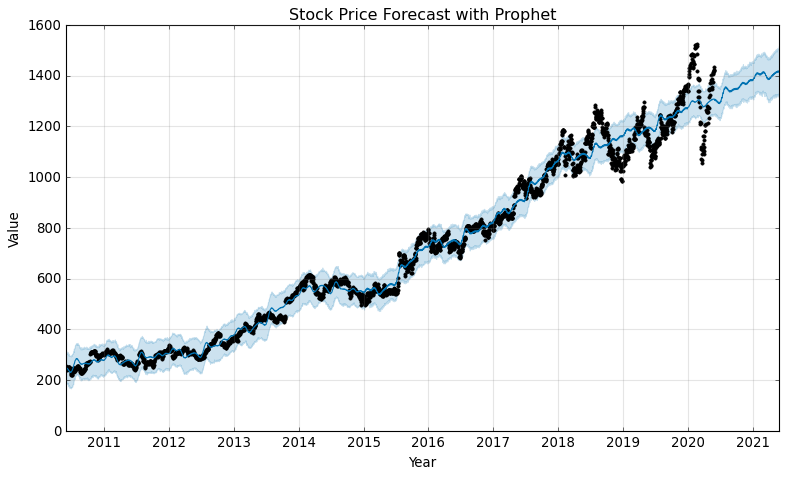

Mean Squared Error: 23421.58289810815
Root Mean Squared Error: 153.041115057713
Mean Absolute Error: 133.04666377321496


In [68]:
# Plotting
y_pred = forecast['yhat'][-365:]
y_true = df_prophet['y'][-365:]
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

fig = model.plot(forecast)
plt.style.use('classic')
plt.title('Stock Price Forecast with Prophet')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

The trend of actual as well as predicted values in the plot  looks to be in the same direction

## Machine Learning based approach

In [69]:
def split_data(df):
    X = df[['Lag_1']]
    y = df['close_value']
    return train_test_split(X, y, test_size=0.2, shuffle=False)

def fit_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, mae

In [70]:
stock['Lag_1'] = stock['close_value'].shift(1)
stock.dropna(inplace=True)

In [71]:
X_train, X_test, y_train, y_test = split_data(stock)

#### SVM Model

In [72]:
from sklearn.svm import SVR

In [73]:
svm_model = SVR()
y_pred_svm = fit_and_predict(svm_model, X_train, y_train, X_test)
mse_svm, rmse_svm, mae_svm = evaluate_model(y_test, y_pred_svm)

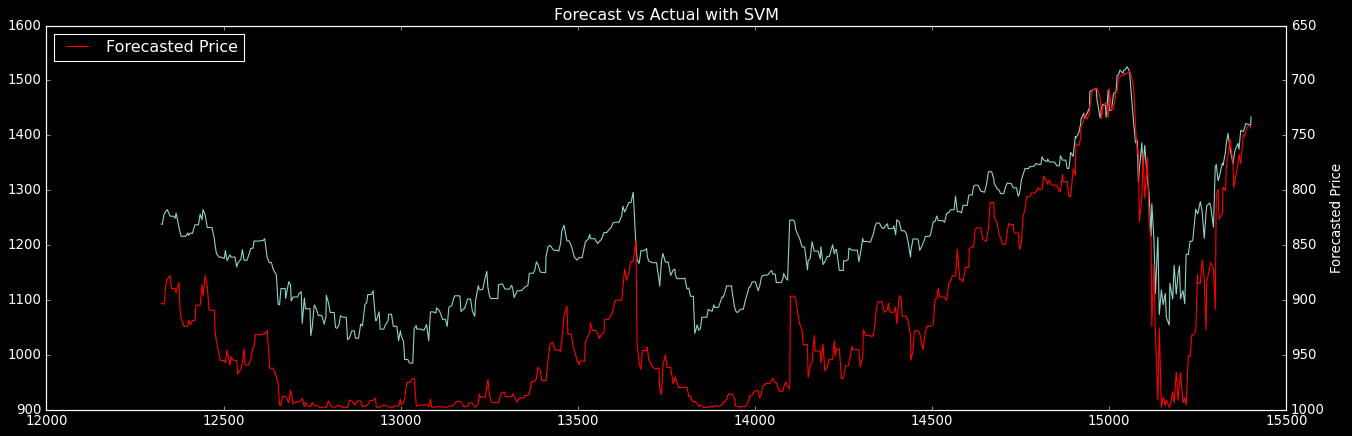

Mean Squared Error: 114062.54954881856
Root Mean Squared Error: 337.7314755080115
Mean Absolute Error: 279.25628290905905


In [75]:
plt.style.use('dark_background')
plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Actual Price')
ax2 = plt.gca().twinx()
ax2.plot(y_test.index, y_pred_svm, label='Forecasted Price', color='red')
ax2.invert_yaxis()
plt.ylabel('Actual Price')
ax2.set_ylabel('Forecasted Price')
plt.title('Forecast vs Actual with SVM')
plt.legend(loc='upper left')
plt.show()

print('Mean Squared Error:', mse_svm)
print('Root Mean Squared Error:', rmse_svm)
print('Mean Absolute Error:', mae_svm)

#### GBR Model

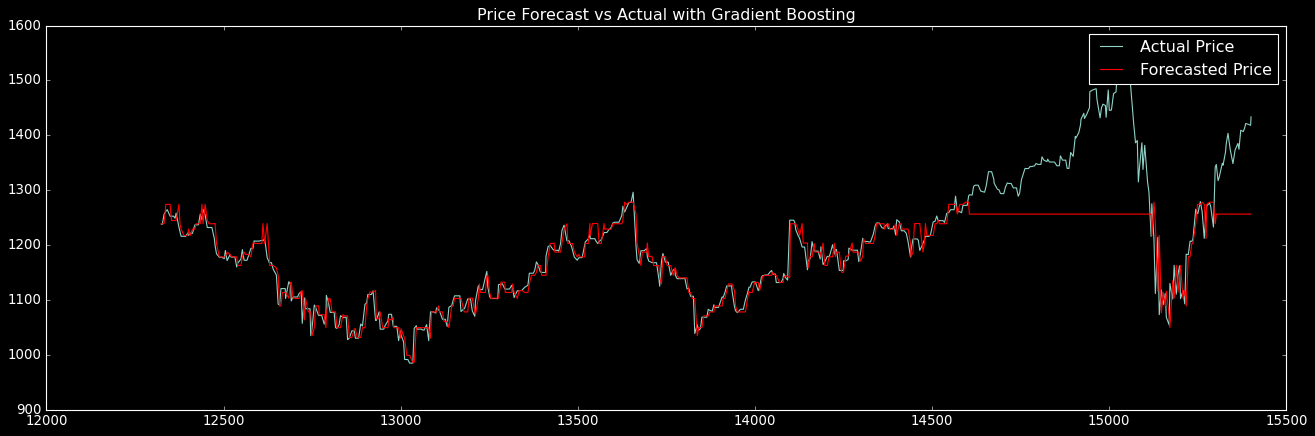

Mean Squared Error: 4095.09006401613
Root Mean Squared Error: 63.992890730268854
Mean Absolute Error: 34.79420137915149


In [76]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100)
y_pred_gb = fit_and_predict(gb_model, X_train, y_train, X_test)
mse_gb, rmse_gb, mae_gb = evaluate_model(y_test, y_pred_gb)

plt.style.use('dark_background')
plt.figure(figsize=(20,6))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, y_pred_gb, label='Forecasted Price', color='red')
plt.title('Price Forecast vs Actual with Gradient Boosting')
plt.legend()
plt.show()

print('Mean Squared Error:', mse_gb)
print('Root Mean Squared Error:', rmse_gb)
print('Mean Absolute Error:', mae_gb)

Both models not fitting very well

## Deep Learning approach

### LSTM (Tensorflow)

In [77]:
stock = individual_stock('GOOGL')

In [78]:
training_data = stock.iloc[:, 2:4].values

In [79]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)

In [80]:
X = []
y = []
for i in range(1, len(stock)):
    X.append(training_set_scaled[i-1:i, 0])
    y.append(training_set_scaled[i, 0])

In [81]:
X = np.asarray(X)
y = np.asarray(y)

In [82]:
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [83]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((2158, 1, 1), (926, 1, 1))

In [84]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 150)         │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 150)         │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0311 - val_loss: 0.0163
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 1.6258e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8607e-04 - val_loss: 7.2833e-05
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4676e-04 - val_loss: 4.1273e-05
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4650e-04 - val_loss: 8.7912e-05
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8649e-04 - val_loss: 1.6507e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8353e-04 - val_loss: 3.6910e-05
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8194e-04 - val_loss: 3.8569e-05
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7031e-04 - val_loss: 3.3264e-05
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7221e-04 - val_loss: 5.0062e-05
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5949e-04 - val_loss: 4.1799e

In [86]:
predicted = model.predict(X)

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [87]:
# Append the predicted values to the list
test_predicted = []

for i in predicted:
  test_predicted.append(i[0])

In [88]:
close = []
for i in training_set_scaled:
  close.append(i[0])

In [89]:
df_predicted = stock[1:][['day_date']]
df_predicted['predictions'] = test_predicted
df_predicted['close_value'] = close[1:]

In [90]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(df, title):   
    fig = px.line(title = title, template='plotly_dark')
    for i in df.columns[1:]:
        fig.add_scatter(x = df['day_date'], y = df[i], name = i)
    fig.show()

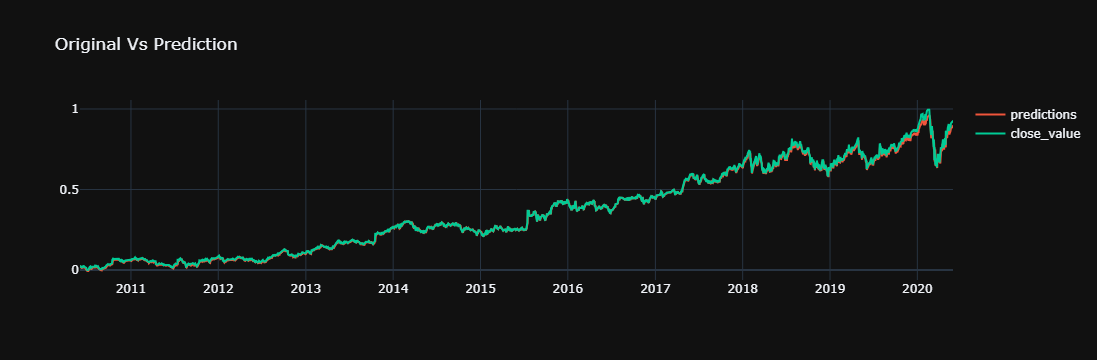

In [91]:
# Plot the data
interactive_plot(df_predicted, "Original Vs Prediction")

### GRU (PyTorch)

In [47]:
data_stock = stock[['day_date', 'open_value', 'high_value', 'low_value', 'close_value', 'volume', 'ticker_symbol']]
data_stock = data_stock.rename(columns={"day_date": "Date", "open_value": "Open", "high_value": "High", "low_value": "Low", "close_value": "Close", "volume": "Volume", "ticker_symbol": "Name"})

In [48]:
data_stock.head()

,Date,Open,High,Low,Close,Volume,Name
2,2010-06-01,242.6868,248.0565,242.5302,243.6667,2664303,GOOGL
4,2010-06-02,245.8439,249.4759,243.2071,249.2233,2513109,GOOGL
8,2010-06-03,250.1023,256.6136,249.8952,255.4013,3646724,GOOGL
12,2010-06-04,252.4310,257.2450,250.9055,251.9259,3909809,GOOGL
18,2010-06-07,252.0976,253.0321,244.0608,245.2580,3628970,GOOGL


In [49]:
price_stock = data_stock[['Close']]

In [50]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price_stock['Close'] = scaler.fit_transform(price_stock['Close'].values.reshape(-1,1))

In [51]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [52]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price_stock, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2452, 19, 1)
y_train.shape =  (2452, 1)
x_test.shape =  (613, 19, 1)
y_test.shape =  (613, 1)


In [53]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [54]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 105

In [55]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [56]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [57]:
import time

In [58]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.19069804251194
Epoch  1 MSE:  0.1599891483783722
Epoch  2 MSE:  0.10874549299478531
Epoch  3 MSE:  0.07868870347738266
Epoch  4 MSE:  0.04917379841208458
Epoch  5 MSE:  0.004480895586311817
Epoch  6 MSE:  0.04954836517572403
Epoch  7 MSE:  0.021606015041470528
Epoch  8 MSE:  0.023620545864105225
Epoch  9 MSE:  0.012050985358655453
Epoch  10 MSE:  0.00478710513561964
Epoch  11 MSE:  0.00937211699783802
Epoch  12 MSE:  0.01688089780509472
Epoch  13 MSE:  0.018053974956274033
Epoch  14 MSE:  0.012997964397072792
Epoch  15 MSE:  0.007309058681130409
Epoch  16 MSE:  0.004471741151064634
Epoch  17 MSE:  0.0037831307854503393
Epoch  18 MSE:  0.0032327971421182156
Epoch  19 MSE:  0.0030703404918313026
Epoch  20 MSE:  0.004931860603392124
Epoch  21 MSE:  0.0069379438646137714
Epoch  22 MSE:  0.0054730940610170364
Epoch  23 MSE:  0.0021145103964954615
Epoch  24 MSE:  0.0006134004797786474
Epoch  25 MSE:  0.0013416347792372108
Epoch  26 MSE:  0.0024558785371482372
Epoch  27 MSE: 

In [59]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

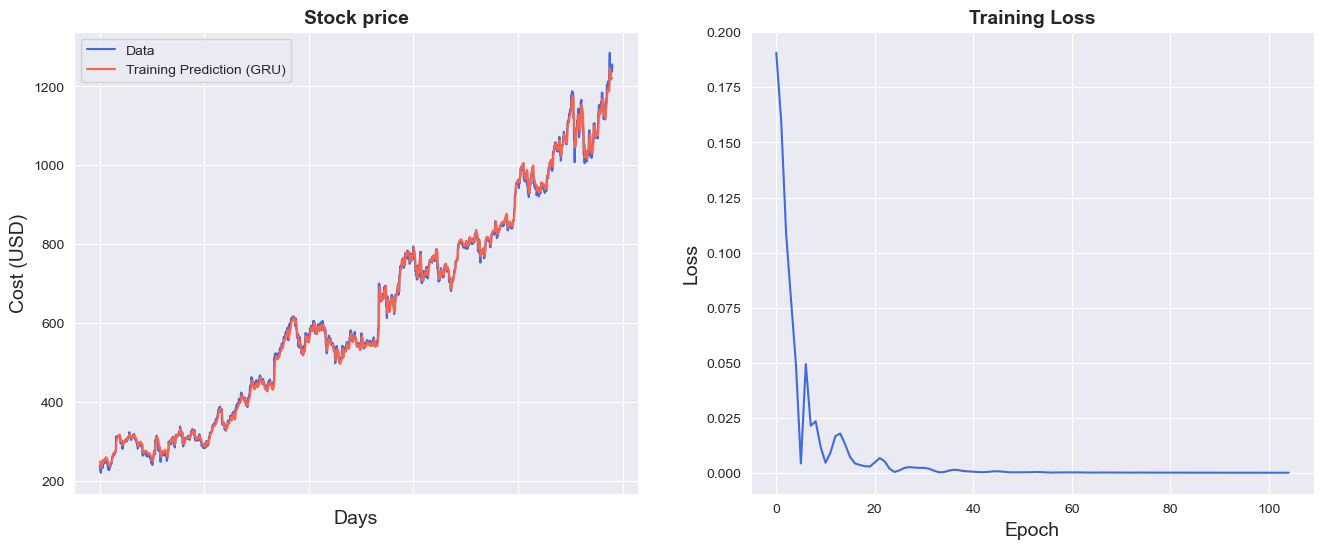

In [60]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [61]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 10.93 RMSE
Test Score: 31.13 RMSE


In [62]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price_stock)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price_stock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price_stock)-1, :] = y_test_pred

original = scaler.inverse_transform(price_stock['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

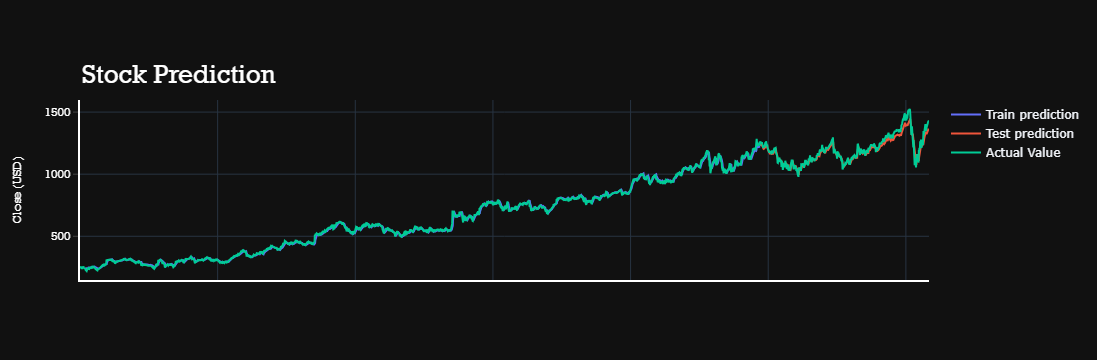

In [63]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Stock Prediction',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()